# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Video based Action Classification using LSTM

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:



*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:**

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN;
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file;
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability;
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

## Grading = 10 Points

### Install and re-start the runtime

In [1]:
!pip3 install imageio==2.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303884 sha256=1dcbb3ab528d78d2bbac0a1d36fbdaa2c8aa1ae5d1a1345a7b548f2b9de71e89
  Stored in directory: /root/.cache/pip/wheels/1b/28/50/248b15750b57c6b163d89d265f242e9cf6bce0bedfea3120aa
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.37.0
    Uninstalling imageio-2.37.0:
      Successfully uninstalled imageio-2.37.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires imageio!=2.35.0,>=2.33, but you have imageio 2.4.1 which is incompatible.
moviepy 1.0.3 requires imageio<3.0,>=2.5; python_version >= "3.4", but you have imageio 2.4.1 which is incompatible.


In [2]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
!unzip -qq Actions.zip
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required packages

In [3]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import GlobalAveragePooling2D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import GRU, Dense, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam

import os, glob
import cv2
import numpy as np

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [5]:
data_dir = "/content/Actions/train/"
test_data_dir = "/content/Actions/test/"
# YOUR CODE HERE

#### Get the length of total frames in the video and take the minimum of it

In [6]:
def get_frame_length_min(input_dir):
    X, Y = [], []
    frame_list = []
    classes_list = sorted(os.listdir(input_dir))

    # print(classes_list)
    for c in classes_list:
        c_dir = os.path.join(input_dir, c)

        files_list = os.listdir(c_dir)

        # print(files_list)
        for f in files_list:

            vidObj = cv2.VideoCapture(os.path.join(c_dir, f))
            total_frames = int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT))
            # print(f"Total frames in the video: {total_frames}")

            frame_list.append(total_frames)


    return min(frame_list)




In [7]:
get_frame_length_min(data_dir)

204

In [8]:
image_size = 128
frames_req = 30

def frames_extraction(video_path):

  frame_list = []

  vidObj = cv2.VideoCapture(video_path)

  count = 0

  while count < frames_req:
    success, image = vidObj.read()

    if success and image is not None:

      image = cv2.resize(image, (image_size,image_size))
      frame_list.append(image)
      count += 1
    else:
      print("Defected frame")
      break

  vidObj.release()
  return frame_list

def create_data(input_dir):
    X, Y = [], []
    classes_list = sorted(os.listdir(input_dir))

    # print(classes_list)
    for c in classes_list:
        c_dir = os.path.join(input_dir, c)

        files_list = os.listdir(c_dir)

        # print(files_list)
        for f in files_list:

            frames = frames_extraction(os.path.join(c_dir, f))


            # if len(frames) == 16:

            X.append(frames)

            y = [0]*len(classes_list)

            y[classes_list.index(c)] = 1

            Y.append(y)

    return np.array(X), np.array(Y)


# Load dataset
X, Y = create_data(data_dir)
print('\n'.join(os.listdir(data_dir)))
X_test, Y_test = create_data(test_data_dir)
print(f"Train shape: {X.shape}, Labels shape: {Y.shape}")
print(f"Test shape: {X_test.shape}, Labels shape: {Y_test.shape}")

Handclapping
jogging
running
Walking
boxing
handwaving
Train shape: (479, 30, 128, 128, 3), Labels shape: (479, 6)
Test shape: (120, 30, 128, 128, 3), Labels shape: (120, 6)


In [9]:
X[0][0].shape

(128, 128, 3)

In [10]:
X[0]

array([[[[230, 230, 230],
         [228, 228, 228],
         [229, 229, 229],
         ...,
         [221, 221, 221],
         [220, 220, 220],
         [222, 222, 222]],

        [[199, 199, 199],
         [199, 199, 199],
         [199, 199, 199],
         ...,
         [189, 189, 189],
         [190, 190, 190],
         [189, 189, 189]],

        [[195, 195, 195],
         [195, 195, 195],
         [197, 197, 197],
         ...,
         [196, 196, 196],
         [190, 190, 190],
         [193, 193, 193]],

        ...,

        [[119, 119, 119],
         [130, 130, 130],
         [117, 117, 117],
         ...,
         [116, 116, 116],
         [115, 115, 115],
         [117, 117, 117]],

        [[117, 117, 117],
         [126, 126, 126],
         [121, 121, 121],
         ...,
         [128, 128, 128],
         [125, 125, 125],
         [126, 126, 126]],

        [[130, 130, 130],
         [124, 124, 124],
         [128, 128, 128],
         ...,
         [136, 136, 136],
        

#### Displaying the images

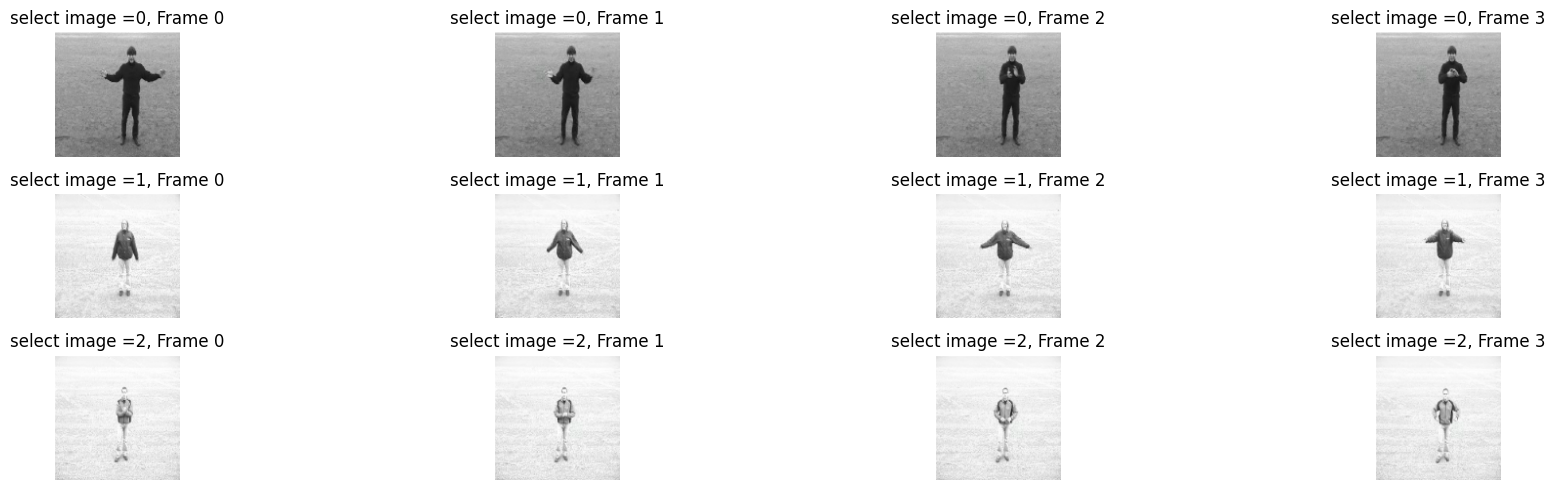

In [11]:
# create 3 rows and 8 columsn for subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 5))

for select_image in range (0,3):
  # selcting from image 0  to image 40 with 5 steps in between
  for col,i in enumerate(range(0,20,5)):

    # choose the axis
    ax = axes[select_image, col]  # Access the correct subplot
    # display the image
    ax.imshow(X[select_image][i])
    ax.axis("off")
    ax.set_title(f"select image ={select_image}, Frame {col}")

plt.tight_layout()
plt.show()

In [12]:
image = Image.fromarray(X[0][0])

# Display the image
image.show()

#### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot

### Create the Neural Network (4 points)

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [13]:
X.shape

(479, 30, 128, 128, 3)

In [14]:
# YOUR CODE HERE
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras.layers import TimeDistributed, Conv2D, Lambda
from keras.regularizers import l2
from keras import models

model_cnlst = models.Sequential()

model_cnlst.add(Lambda(lambda x: x/255.0,input_shape=(30, 128, 128, 3)))

model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(2,2),activation='relu')))
model_cnlst.add(TimeDistributed(BatchNormalization()))  # BatchNorm before pooling
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))


model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(BatchNormalization()))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))


model_cnlst.add(TimeDistributed(Conv2D(16, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(BatchNormalization()))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))

model_cnlst.add(TimeDistributed(Conv2D(8, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(BatchNormalization()))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))



model_cnlst.add(TimeDistributed(Flatten()))
model_cnlst.add(Dropout(0.2))
model_cnlst.add(LSTM(64,return_sequences=True)) # used 32 units
model_cnlst.add(LSTM(32,return_sequences=False))


# ADDING THE DENSE LAYERS
model_cnlst.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_cnlst.add(Dropout(0.2))
# model_cnlst.add(Dense(64,activation='relu'))
# model_cnlst.add(Dropout(0.2))

model_cnlst.add(Dense(6, activation='softmax'))
model_cnlst.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 30, 128, 128, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 63, 63, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 63, 63, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 31, 31, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 30, 29, 29, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 30, 29, 29, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 30, 14, 14, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 30, 12, 12, 16)      │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 30, 12, 12, 16)      │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 30, 6, 6, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 30, 4, 4, 8)         │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 30, 4, 4, 8)         │              32 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 30, 2, 2, 8)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 30, 32)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             7

 Total params: 68,766 (268.62 KB)

 Trainable params: 68,526 (267.68 KB)

 Non-trainable params: 240 (960.00 B)

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [15]:
import tensorflow as tf

In [16]:
!pip install pyyaml h5py  # Required to save models in HDF5 format.

In [17]:
print(tf.version.VERSION)

2.18.0


In [18]:
from tensorflow.keras import backend as K
K.clear_session()

In [19]:
# Note: There will be a high memory requirement for the training steps below.
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

# YOUR CODE HERE
# define the path
model_cnlst.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint_path = "training_4/cp.weights.h5" # Since you're only saving weights, you should use the .weights.h5 extension. If you're saving the whole model, you would use the .keras extension instead
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model_cnlst.fit(
    X,
    Y,
    batch_size=32,
    epochs=40,
    validation_data=(X_test,Y_test),
    callbacks=[cp_callback])


Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.2269 - loss: 2.2384
Epoch 1: saving model to training_4/cp.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 719ms/step - accuracy: 0.2296 - loss: 2.2350 - val_accuracy: 0.2000 - val_loss: 2.1643
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.3854 - loss: 1.9585
Epoch 2: saving model to training_4/cp.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.3861 - loss: 1.9535 - val_accuracy: 0.3833 - val_loss: 1.7463
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.4228 - loss: 1.6253
Epoch 3: saving model to training_4/cp.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.4235 - loss: 1.6218 - val_accuracy: 0.5000 - val_loss: 1.4560
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.5823 - loss: 1.3906
Epoch 4: saving model to training_4/cp.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.5811 - loss: 1.3892 - val_accuracy: 0.5000 - val_

In [23]:
class_names = ['Handclapping', 'Walking', 'boxing', 'handwaving', 'jogging', 'running']

In [22]:
def plot_confusion_matrix(model, X_test, Y_test):

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(Y_test, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


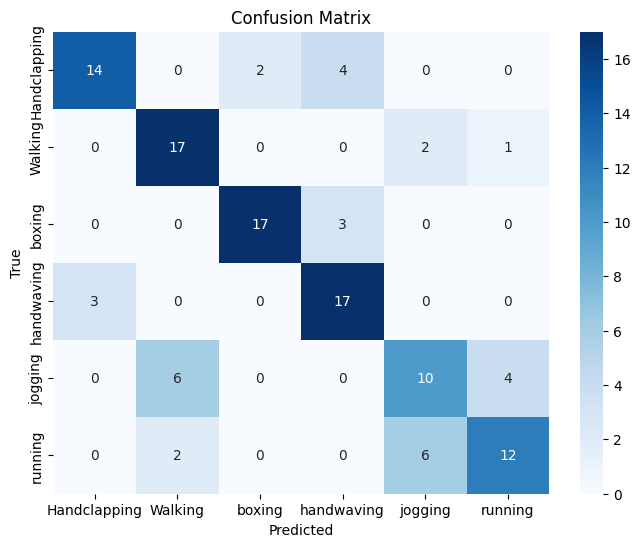

In [24]:
plot_confusion_matrix(model_cnlst, X_test, Y_test)

### Use pre-trained model for feature extraction (3 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

In [25]:
# YOUR CODE HERE
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#### Augment the Data based on train_datagen

In [27]:
def augment_data(X):

  augmented_x = []
  for video in X:
      image_list = []
      for img in video:
          # print(img.shape)
          i
          augmented_image = train_datagen.random_transform(img)
          image_list.append(augmented_image)

      augmented_x.append(image_list)

  return np.array(augmented_x)/255.0


augmented_x = augment_data(X)

In [28]:
augmented_x

array([[[[[0.64705882, 0.64705882, 0.64705882],
          [0.63921569, 0.63921569, 0.63921569],
          [0.63529412, 0.63529412, 0.63529412],
          ...,
          [0.74117647, 0.74117647, 0.74117647],
          [0.72941176, 0.72941176, 0.72941176],
          [0.72156863, 0.72156863, 0.72156863]],

         [[0.67058824, 0.67058824, 0.67058824],
          [0.67058824, 0.67058824, 0.67058824],
          [0.6745098 , 0.6745098 , 0.6745098 ],
          ...,
          [0.74509804, 0.74509804, 0.74509804],
          [0.73333333, 0.73333333, 0.73333333],
          [0.73333333, 0.73333333, 0.73333333]],

         [[0.67843137, 0.67843137, 0.67843137],
          [0.6745098 , 0.6745098 , 0.6745098 ],
          [0.67058824, 0.67058824, 0.67058824],
          ...,
          [0.7372549 , 0.7372549 , 0.7372549 ],
          [0.74117647, 0.74117647, 0.74117647],
          [0.74509804, 0.74509804, 0.74509804]],

         ...,

         [[0.53333333, 0.53333333, 0.53333333],
          [0.54901961,

#### Plotting the Augmented Images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and subplots
fig, axes = plt.subplots(5, 6, figsize=(20, 5))  # 3 rows, 4 columns
fig.suptitle('Augmented Images', fontsize=16)  # Add a title to the figure

# Generate augmented images and plot them
for i in range(5):  # Plot 12 images (3 rows × 4 columns)
    # batch = next(train_generator)  # Get the next batch of augmented images
    # augmented_image = batch[0][i]  # Extract the first image from the batch
    # augmented_image = augmented_image.astype(np.uint8)  # Convert to uint8 for display
    for j in range(6):

      # Plot the augmented image
      ax = axes[i,j]  # Get the current subplot axis
      ax.imshow(augmented_x[0][i+j])
      ax.axis('off')  # Hide axes
      ax.set_title(f'Augmented Image {i + j}')  # Add a title to each subplot

plt.tight_layout()
plt.show()

#### Load and fine-tune the pre-trained model VGG16

In [30]:

# Remove the Dense layers of VGG16,
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128,128,3))
# base_model.summary()

# freeze 60 percent of the layers for training
for layer in base_model.layers[:int(0.60*len(base_model.layers))]:

    layer.trainable = False

base_model.summary()

model = Sequential()

# TimeDistributed wraps around the base model
model.add(TimeDistributed(base_model, input_shape=(30,128,128,3)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True)) # used 32 units
model.add(LSTM(32,return_sequences=False))


# ADDING THE DENSE LAYERS
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
# model_cnlst.add(Dense(64,activation='relu'))
# model_cnlst.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 30, 4, 4, 512)       │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 64)              │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,879,814 (56.76 MB)

 Trainable params: 13,144,326 (50.14 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [31]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


checkpoint_path = "training_5/cp.weights.h5" # Since you're only saving weights, you should use the .weights.h5 extension. If you're saving the whole model, you would use the .keras extension instead
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model
history = model.fit(
    augmented_x,
    Y,
    batch_size=36,
    epochs=20,
    validation_data=(X_test, Y_test),
    callbacks=[cp_callback]
)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.2052 - loss: 2.2774
Epoch 1: saving model to training_5/cp.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 822ms/step - accuracy: 0.2071 - loss: 2.2760 - val_accuracy: 0.1833 - val_loss: 2.2950
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3141 - loss: 2.1509
Epoch 2: saving model to training_5/cp.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.3151 - loss: 2.1492 - val_accuracy: 0.3417 - val_loss: 2.1962
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.2934 - loss: 2.0530
Epoch 3: saving model to training_5/cp.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.2972 - loss: 2.0516 - val_accuracy: 0.2000 - val_loss: 2.2287
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.3899 - loss: 1.9785
Epoch 4: saving model to training_5/cp.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.3889 - loss: 1.9781 - val_accuracy: 0.2250 - val_

#### Plotting the Training loss and validation loss

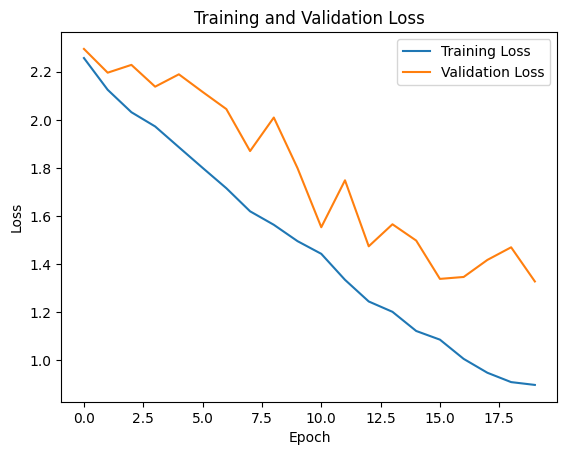

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

#### Plotting the ConfusionMatrix

In [33]:
# YOUR CODE HERE
def plot_confusion_matrix(model, X_test, Y_test):

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(Y_test, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


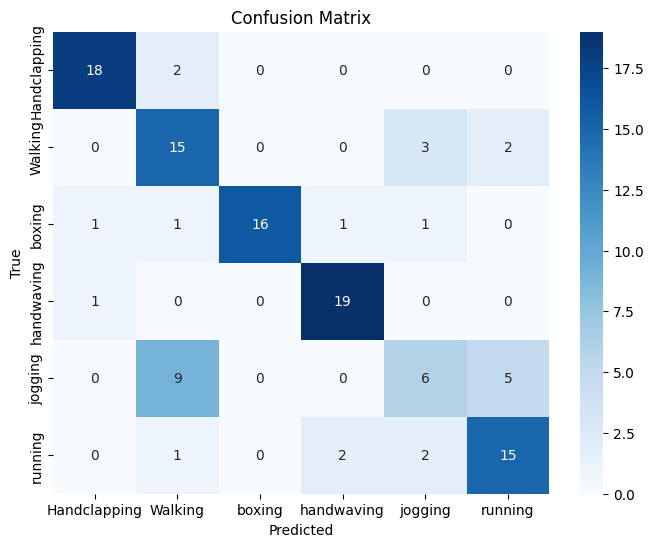

In [34]:
plot_confusion_matrix(model, X_test, Y_test)

### Report Analysis

* Discuss on FPS, Number of frames and duration of each video
* Analyze the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and ConvNet
* *Additional Reading*: Read and discuss about the use of Conv3D in video classification